# DSC 291 (Fall 2020) Final project: Nonparametric CCA

**Jiun-Ting Huang and Jongha (Jon) Ryu**


In this notebook, we present some preliminary results with a toy example (spiral dataset below).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_decomposition import CCA as CCA_sklearn

from cca import CCA
from ncca import GaussianKdeNCCA, KnnNCCA
from kcca import GaussianKernelCCA

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('ggplot')

## Spiral data 

In [4]:
from utils import spiral_2d

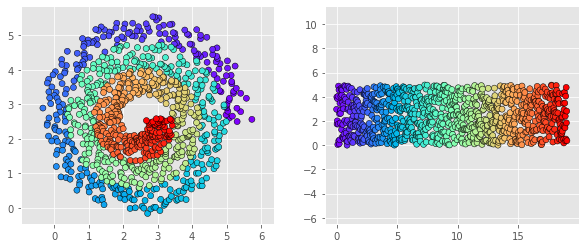

In [5]:
# Generate data
X, c = spiral_2d(1)
X = X * 5
Y, c = np.stack([c, 5 * np.random.uniform(size=len(c))], axis=1).T, c

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].scatter(X[0], X[1], c=c, cmap='rainbow', edgecolors='black')
axes[0].axis('equal');
axes[1].scatter(Y[0], Y[1], c=c, cmap='rainbow', edgecolors='black')
axes[1].axis('equal');

## 1. CCA

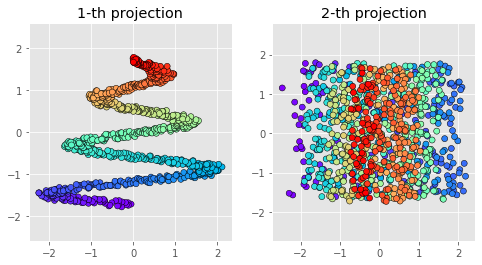

In [6]:
cca = CCA().fit(X, Y)
X_c, Y_c = cca.project(X, Y)

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for j in range(2):
    axes[j].set_title("{}-th projection".format(j+1))
    axes[j].scatter(X_c[j], Y_c[j], c=c, cmap='rainbow', edgecolors='black')
    axes[j].axis('equal');

As expected, CCA, which is linear, cannot capture the nonlinear structure.

## 2. Kernel CCA with Gaussian kernels

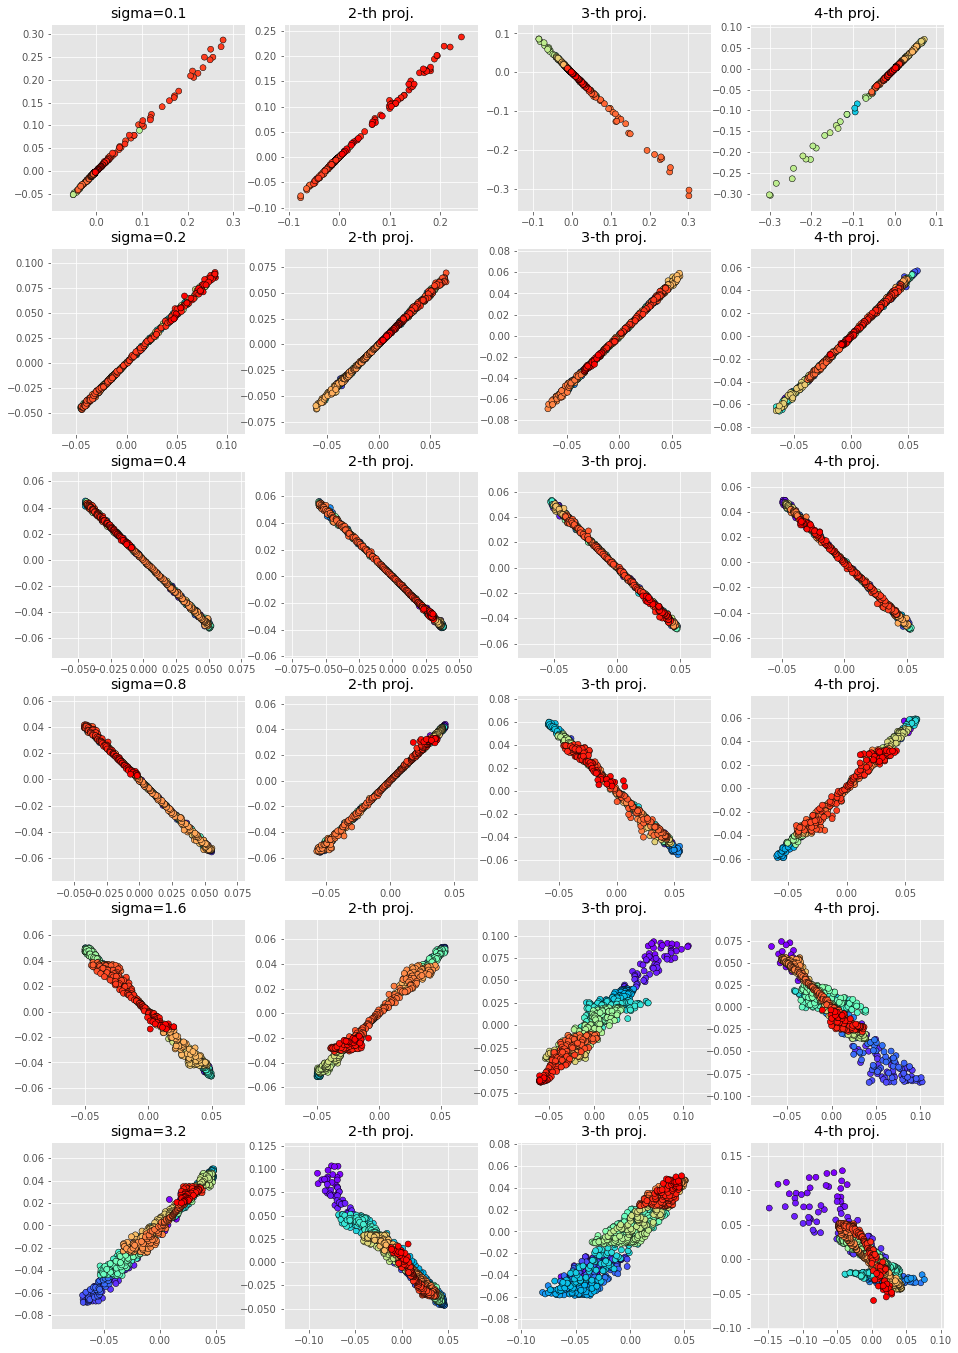

In [7]:
sigmas = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
figs, axes = plt.subplots(nrows=len(sigmas), ncols=4, figsize=(16, 4 * len(sigmas)))

for ik, sigma in enumerate(sigmas):
    sigma_x = sigma_y = sigma
    kcca = GaussianKernelCCA(rx=0.1, ry=0.1, sigma_x=sigma_x, sigma_y=sigma_y).fit(X, Y)
    X_c = kcca.projections_x
    Y_c = kcca.projections_y

    for i in range(4):
        axes[ik][i].scatter(X_c[i], Y_c[i], c=c, cmap='rainbow', edgecolors='black')
        axes[ik][i].axis('equal');
        if i > 0:
            axes[ik][i].set_title("{}-th proj.".format(i+1))
    axes[ik][0].set_title("sigma={}".format(sigma_x), fontsize=14)

For this example, Gaussian kernel CCA can capture almost perfect correlation.

## 2. NCCA with Gaussian KDE (original method)

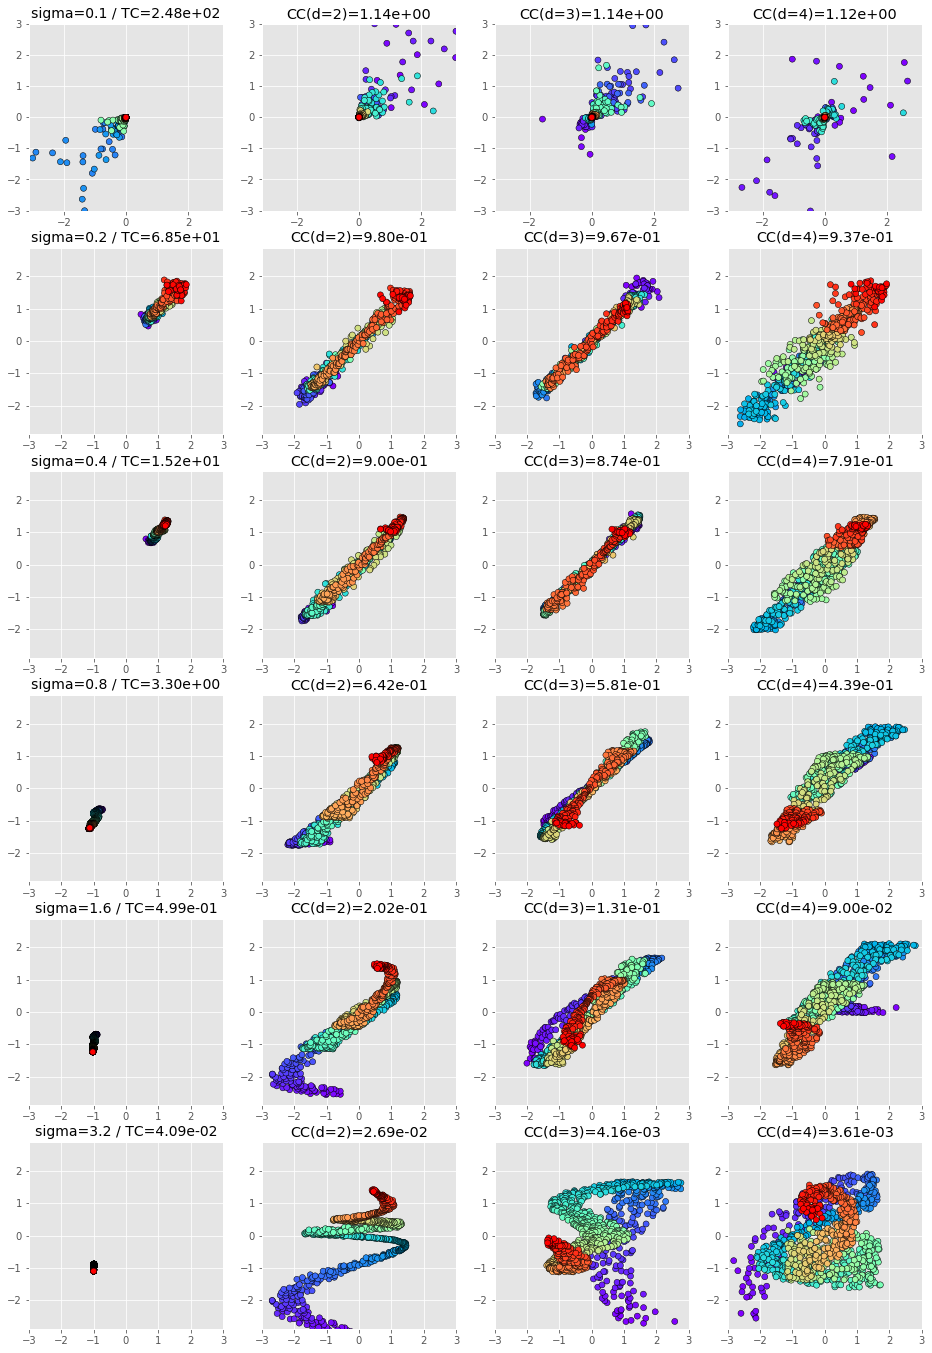

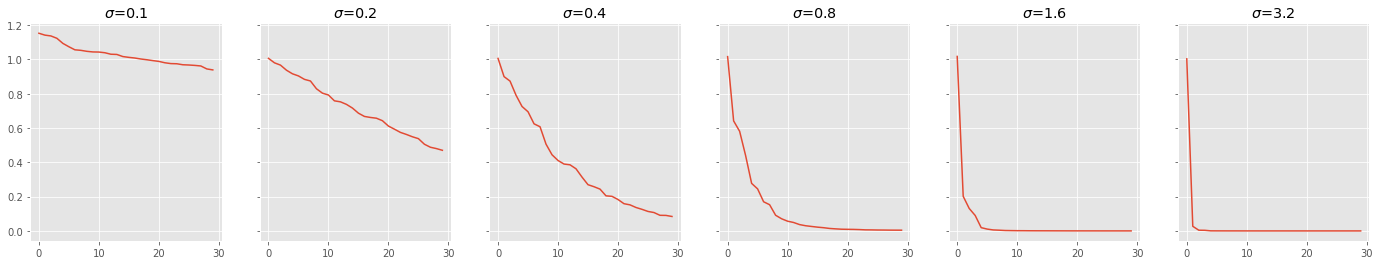

In [8]:
sigmas = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
figs, axes = plt.subplots(nrows=len(sigmas), ncols=4, figsize=(16, 4 * len(sigmas)))

ccs = []

for ik, sigma in enumerate(sigmas):
    sigma_x = sigma_y = sigma
    ncca = GaussianKdeNCCA(sigma_x=sigma_x, sigma_y=sigma_y).fit(X, Y)
    X_c = ncca.projections_x
    Y_c = ncca.projections_y

    for i in range(4):
        axes[ik][i].scatter(X_c[i], Y_c[i], c=c, cmap='rainbow', edgecolors='black')
        axes[ik][i].axis('equal');
        axes[ik][i].set_xlim([-3, 3]);
        axes[ik][i].set_ylim([-3, 3]);
        if i > 0:
            axes[ik][i].set_title("CC(d={})={:.2e}".format(i+1, ncca.canonical_correlations[i]))
    axes[ik][0].set_title("sigma={} / TC={:.2e}".format(sigma_x, ncca.canonical_correlations[1:].sum()), fontsize=14)
    ccs.append(ncca.canonical_correlations)
    
figs, axes = plt.subplots(ncols=len(sigmas), nrows=1, figsize=(4 * len(sigmas), 4), sharey=True)
for ik, sigma in enumerate(sigmas):
    axes[ik].set_title('$\sigma$={}'.format(sigma))
    axes[ik].plot(ccs[ik][:30])

As we increase the bandwidth, the correlation structures become weaker. In other words, NCCA is sensitive to the choice of bandwidths.(Note that the first projections are either +1 or -1, as expceted from theory.)

## 3. NCCA with self-tuned bandwidth

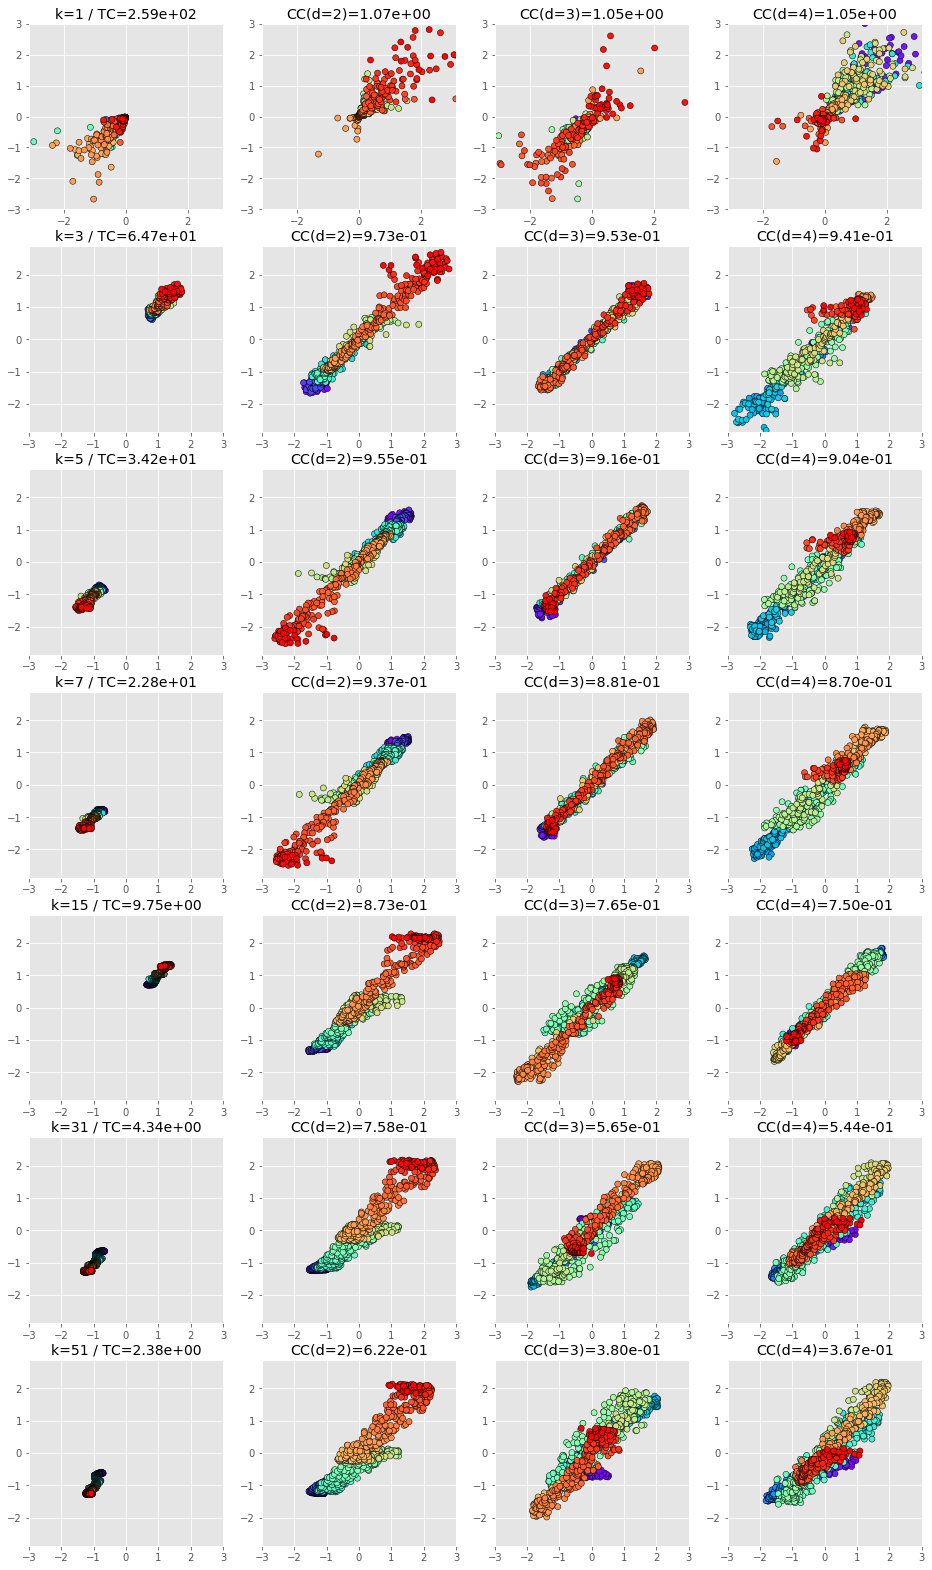

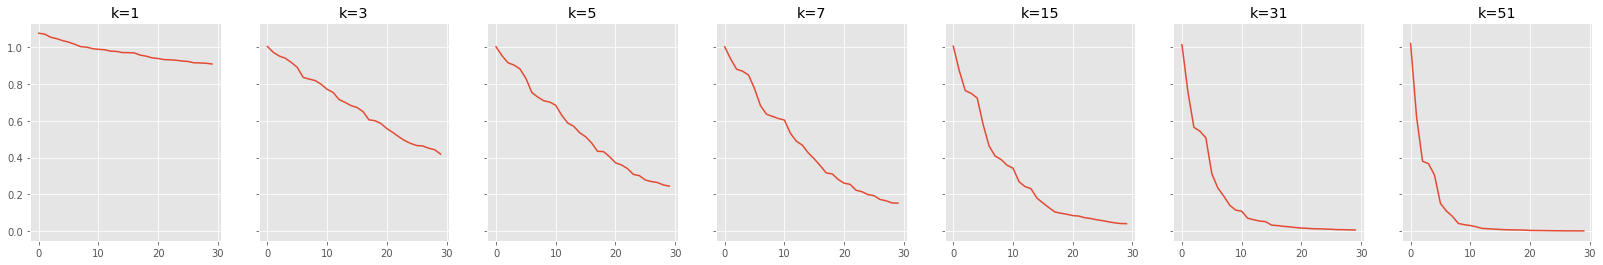

In [9]:
ks = [1, 3, 5, 7, 15, 31, 51]
figs, axes = plt.subplots(nrows=len(ks), ncols=4, figsize=(16, 4 * len(ks)))

ccs = []

for ik, k in enumerate(ks):
    ncca = GaussianKdeNCCA(self_tuning_k=k).fit(X, Y)
    X_c = ncca.projections_x
    Y_c = ncca.projections_y

    for i in range(4):
        axes[ik][i].scatter(X_c[i], Y_c[i], c=c, cmap='rainbow', edgecolors='black')
        axes[ik][i].axis('equal');
        axes[ik][i].set_xlim([-3, 3]);
        axes[ik][i].set_ylim([-3, 3]);
        if i > 0:
            axes[ik][i].set_title("CC(d={})={:.2e}".format(i+1, ncca.canonical_correlations[i]))
    axes[ik][0].set_title("k={} / TC={:.2e}".format(k, ncca.canonical_correlations[1:].sum()), fontsize=14)
    ccs.append(ncca.canonical_correlations)
    
figs, axes = plt.subplots(ncols=len(ks), nrows=1, figsize=(4 * len(ks), 4), sharey=True)
for ik, k in enumerate(ks):
    axes[ik].set_title('k={}'.format(k))
    axes[ik].plot(ccs[ik][:30])

With the self-tuned bandwidths the overall method becomes stabilized in the sense that correlation strucutres are well captured, for the moderate choices of $k$, e.g., $k\{3, 5, 7, 15\}$.

## 4. NCCA with k-NN density estimators

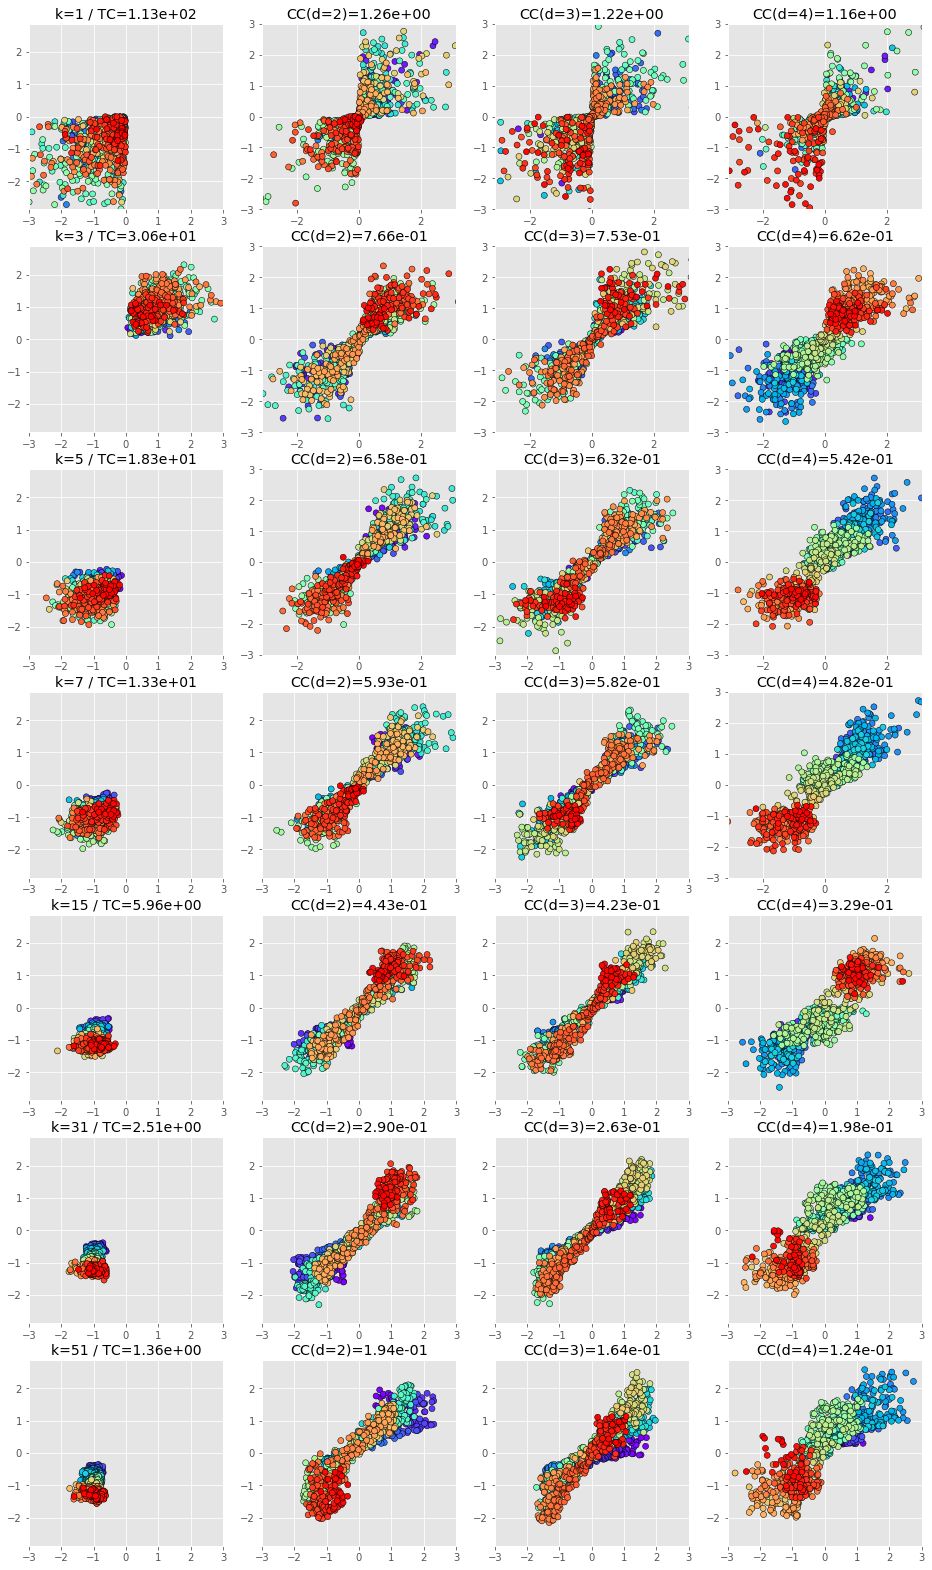

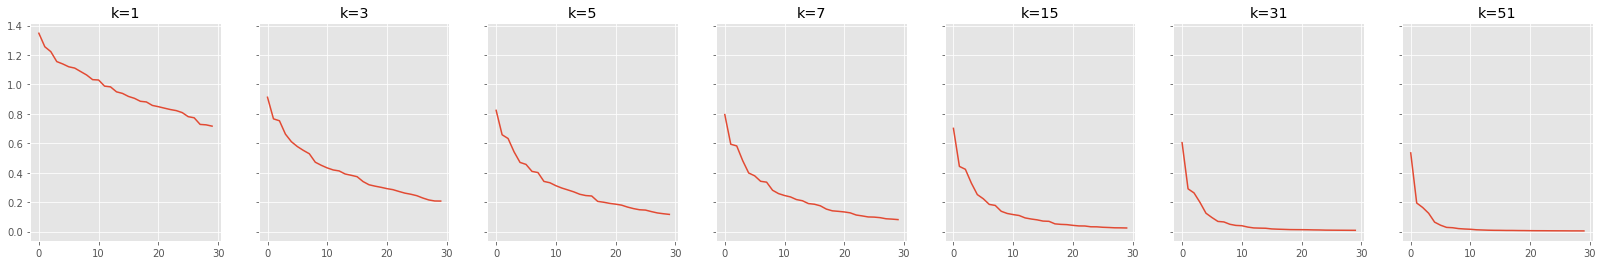

In [10]:
ks = [1, 3, 5, 7, 15, 31, 51]
figs, axes = plt.subplots(nrows=len(ks), ncols=4, figsize=(16, 4 * len(ks)))

ccs = []

for ik, k in enumerate(ks):
    ncca = KnnNCCA(kx=k, ky=k, kxy=k).fit(X, Y)
    X_c = ncca.projections_x
    Y_c = ncca.projections_y

    for i in range(4):
        axes[ik][i].scatter(X_c[i], Y_c[i], c=c, cmap='rainbow', edgecolors='black')
        axes[ik][i].axis('equal');
        axes[ik][i].set_xlim([-3, 3]);
        axes[ik][i].set_ylim([-3, 3]);
        if i > 0:
            axes[ik][i].set_title("CC(d={})={:.2e}".format(i+1, ncca.canonical_correlations[i]))
    axes[ik][0].set_title("k={} / TC={:.2e}".format(k, ncca.canonical_correlations[1:].sum()), fontsize=14)
    ccs.append(ncca.canonical_correlations)
    
figs, axes = plt.subplots(ncols=len(ks), nrows=1, figsize=(4 * len(ks), 4), sharey=True)
for ik, k in enumerate(ks):
    axes[ik].set_title('k={}'.format(k))
    axes[ik].plot(ccs[ik][:30])

We tried $k$-nearest neighbor density estimators in place of the kernel density estimators. As shown here, this idea does not improve the performance compared to the original method. Also, as the joint density estimate is not in a separable form, computational complexity becomes much worse than the original separable KDE based method.